# Modeling Aboveground Biomass Density Using GEDI, Sentinel-2, SAR Imagery, and Machine Learning: An Introductory Guide with Python
## Aim
The script aims to model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A) dataset, Sentinel-1 (S1), L-band Synthetic Aperture Radar (PALSAR), Sentinel-2 (S2), spectral indices, Shuttle Radar Topography Mission (SRTM) digital elevation model (elevation and slope), and a random forest method. We use Mafungautsi Forest Reserve as the test site.

## Requirements
To run this script, the user must have an Earth Engine account. In addition, the user must authenticate the Earth Engine Python API. See the instructions [here](https://developers.google.com/earth-engine/guides/auth).


This script will use the [geemap](https://geemap.org) Python package to visualize, analyze and compute AGBD. Geemap enables users to interactively explore and visualize Earth Engine datasets within a Jupyter-based environment with minimal coding. To learn more about geemap, check out https://geemap.org.

Following are the steps to model AGBD.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import the API
import ee

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='mynewproject-408210')

## Import Libraries
Import the essential libraries needed to process and analyze the datasets.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import boxcox
import joblib
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#import spyndex
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm
import pickle as pk
from lightgbm import LGBMRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_validate

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline

import geopandas as gpd
import json
import geemap
geemap.update_package
from shapely.geometry import shape, Point, mapping

# set to avoid receiving warnings
import warnings
warnings.filterwarnings("ignore")

# Import Datasets
## Import the project boundary
First, import the forest reserve project boundary from the Google Earth Engine catalog's World Database on Protected Areas ('WCMC/WDPA/current/polygons'). The World Database on Protected Areas (WDPA) is the most up-to-date and comprehensive source of information on protected areas, updated monthly with submissions from governments, non-governmental organizations, landowners, and communities. It is managed by the United Nations Environment Programme's World Conservation Monitoring Centre (UNEP-WCMC) with support from the IUCN and its World Commission on Protected Areas (WCPA). You can select your project forest reserve or protected area from the WDPA database.

Source: https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons



In [ ]:
# Load the World Database on Protected Areas (WDPA) dataset
wdpa = ee.FeatureCollection('WCMC/WDPA/current/polygons')

# Search for protected areas in Côte d'Ivoire (ISO3 code is CIV)
civ_protected_areas = wdpa.filter(ee.Filter.eq('ISO3', 'CIV'))

# Print the names of protected areas in Côte d'Ivoire to the console to find Tai Forest
areas_names = civ_protected_areas.aggregate_array('NAME').getInfo()

# Print the names of the protected areas
print(areas_names)

['Taï National Park', 'Comoé National Park', 'Divo', 'Soukourou', 'Pouniokele', 'Classified Forest Name Unknown (CIV) No.1', 'Classified Forest Name Unknown (CIV) No.2', 'Lougbo', 'Ouarigue', 'Tinrido', 'Gbanala', 'Samatiguila', 'Lapale', 'Konza Kourou', 'Classified Forest Name Unknown (CIV) No.3', 'Classified Forest Name Unknown (CIV) No.4', 'Lopboho', 'Boundiali', 'Classified Forest Name Unknown (CIV) No.5', 'Classified Forest Name Unknown (CIV) No.6', 'Classified Forest Name Unknown (CIV) No.7', 'Classified Forest Name Unknown (CIV) No.8', 'Odinne', 'Bdoule', 'Classified Forest Name Unknown (CIV) No.9', 'Classified Forest Name Unknown (CIV) No.10', 'Foula', 'Gouari', 'Zandougou', "N'zi Superieure", 'Classified Forest Name Unknown (CIV) No.11', 'Classified Forest Name Unknown (CIV) No.12', 'Foumbou', 'Classified Forest Name Unknown (CIV) No.13', 'Classified Forest Name Unknown (CIV) No.14', 'Yani', 'Nyellepuo', 'Classified Forest Name Unknown (CIV) No.15', 'Classified Forest Name Unk

In [ ]:
# Define the boundary for Tai forest reserve
tai_forest_boundary = wdpa.filter(ee.Filter.inList('NAME', ['Parc national de Taï']))

# Define the boundary for Banco forest reserve
banco_forest_boundary = wdpa.filter(ee.Filter.inList('NAME', ['Parc national du Banco']))

## Create Sentinel-2 composite
The sentinel-2 mission offers a wide-swath, high-resolution, multispectral imaging capability with a global 5-day revisit frequency. The Sentinel-2 Multispectral Instrument (MSI) has 13 spectral bands, providing a comprehensive view of the Earth's surface. These bands are distributed as four at 10 meters, six at 20 meters, and three at 60 meters spatial resolution. For more detailed information about the Sentinel-2 mission, please visit https://sentinel.esa.int/web/sentinel/missions/sentinel-2.


In [ ]:
# Load Sentinel-2 spectral reflectance data.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Create a function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

def maskLowQA(img):
  qaBand = 'cs_cdf'
  clearThreshold = 0.6
  mask = img.select(qaBand).gte(clearThreshold)
  return img.updateMask(mask)

# Create a single composite image for a given period.
start_date = '2023-01-01'
end_date = '2023-12-31'


def processing_s2_images(start_date, end_date, aoi):
  image_coll = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(start_date, end_date).filterBounds(aoi)\
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])

  proj = ee.Image(image_coll.first()).select('B4').projection()

  csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
  csPlusBands = csPlus.first().bandNames()
  filteredS2WithCs = image_coll.linkCollection(csPlus,csPlusBands)
  s2Processed = filteredS2WithCs.map(maskLowQA).map(lambda image: image.clip(aoi))

  composite = s2Processed.median().setDefaultProjection(proj)

  return composite

# Filter clouds from Sentinel-2 for the given period.
#composite = s2.filterDate(start_date, end_date) \
#    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
#    .map(maskS2clouds) \
#    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])  # Select bands for display

# Compute the median composite and clip to the boundary.
#S2_composite = composite.median().clip(tai_forest_boundary)
S2_composite = processing_s2_images(start_date, end_date, tai_forest_boundary)

In [ ]:
# Create a map object
mymap = geemap.Map()
mymap.addLayerControl()
mymap.centerObject(tai_forest_boundary, 9)
mymap.addLayer(tai_forest_boundary.style(color='red', width=2), {}, 'Tai Forest Boundary')
#mymap.addLayer(banco_forest_boundary.style(color='red', width=2), {}, 'Banco Forest Boundary')

# Add the composite image to the map with specified display settings.
mymap.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

mymap

Map(center=[5.740724998564172, -7.135868979608726], controls=(WidgetControl(options=['position', 'transparent_…

## Compute spectral indices
In this work, we will utilize the normalized difference vegetation index (NDVI), Normalized Difference Red Edge Index (NDRE), Enhanced Vegetation Index (EVI), Green Normalized Difference Vegetation Index (GNDVI), Ratio Vegetation Index (RVI), Wide Dynamic Range Vegetation Index (WDRVI), Soil-Adjusted Vegetation Index (SAVI), Modified Soil Adjusted Vegetation Index (MSAVI), Canopy Chlorophyll Content Index (CCCI), Red Edge Chlorophyll Index (CIred-edge) and Red Edge Spectral Index (RESI).

In [ ]:
# NDVI (Normalized Difference Vegetation Index)
ndvi = S2_composite.normalizedDifference(['B8', 'B4']).rename('NDVI')

# EVI (Enhanced Vegetation Index)
evi = S2_composite.expression(
    'G * ((NIR - RED) / (NIR + C1 * RED - C2 * BLUE + L))', {
        'NIR': S2_composite.select('B8'),
        'RED': S2_composite.select('B4'),
        'BLUE': S2_composite.select('B2'),
        'G': 2.5,  # Gain factor
        'C1': 6,
        'C2': 7.5,
        'L': 1  # Canopy background adjustment
    }).rename('EVI')

# NDRE (Normalized Difference Red Edge Index)
ndre = S2_composite.normalizedDifference(['B8', 'B5']).rename('NDRE')

# 4. RVI (Ratio Vegetation Index)
rvi = S2_composite.expression(
    'NIR / RED', {
        'NIR': S2_composite.select('B8'),
        'RED': S2_composite.select('B4')
    }).rename('RVI')

# GNDVI (Green Normalized Difference Vegetation Index)
gndvi = S2_composite.normalizedDifference(['B8', 'B3']).rename('GNDVI')

# SAVI (Soil Adjusted Vegetation Index)
L = 0.5  # Soil adjustment factor, typically between 0 and 1
savi = S2_composite.expression(
    '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
        'NIR': S2_composite.select('B8'),
        'Red': S2_composite.select('B4'),
        'L': L
    }).rename('SAVI')

# MSAVI (Modified Soil Adjusted Vegetation Index)
msavi = S2_composite.expression(
    '(2 * NIR + 1 - sqrt((2 * NIR + 1) ** 2 - 8 * (NIR - RED))) / 2', {
        'NIR': S2_composite.select('B8'),
        'RED': S2_composite.select('B4')
    }).rename('MSAVI')

# WDRVI (Wide Dynamic Range Vegetation Index)
wdrvi = S2_composite.expression(
    'a * ((NIR - RED) / (NIR + RED))', {
        'NIR': S2_composite.select('B8'),
        'RED': S2_composite.select('B4'),
        'a': 0.2  # Weighting coefficient for dense vegetation
    }).rename('WDRVI')

# CIred-edge (Red Edge Chlorophyll Index)
ciredge = S2_composite.expression(
    '(NIR / RedEdge) - 1', {
        'NIR': S2_composite.select('B8'),
        'RedEdge': S2_composite.select('B5')
    }).rename('CIred-edge')

# CCCI (Canopy Chlorophyll Content Index)
ccci = S2_composite.expression(
    'NDRE / NDVI', {
        'NDRE': ndre,
        'NDVI': ndvi
    }).rename('CCCI')

# RESI (Red Edge Simple Ratio Index)
resi = S2_composite.expression(
    '((RE3 + RE2 - RE1) / (RE3 + RE2 + RE1))', {
        'RE1': S2_composite.select('B5'),
        'RE2': S2_composite.select('B6'),
        'RE3': S2_composite.select('B7')
    }).rename('RESI')

In [ ]:
# Initialize our map.
mymap2 = geemap.Map()
mymap2.centerObject(tai_forest_boundary, 9)

# Add the vegetation indices layers to the map.
mymap2.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
mymap2.addLayer(evi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'EVI')
mymap2.addLayer(ndre, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDRE')
mymap2.addLayer(rvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RVI')
mymap2.addLayer(gndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'GNDVI')
mymap2.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SAVI')
mymap2.addLayer(msavi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'MSAVI')
mymap2.addLayer(wdrvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'WDRVI')
mymap2.addLayer(ciredge, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'CIREDGE')
mymap2.addLayer(ccci, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'CCCI')
mymap2.addLayer(resi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RESI')


# Display the map with layer control.
mymap2.addLayerControl()
mymap2

Map(center=[5.740724998564172, -7.135868979608726], controls=(WidgetControl(options=['position', 'transparent_…

## Load other datasets
Import other datasets such as the Shuttle Radar Topography Mission (SRTM) digital elevation model (DEM). Add the SRTM DEM data and calculate slope.

In [ ]:
# Load SRTM DEM
srtm = ee.Image("USGS/SRTMGL1_003")

#srtm_resampled = srtm.resample('bilinear').reproject({
#  'crs': srtm.projection(),
#  'scale': 10 })
#print('Resampled Resolution:', resampled.projection().nominalScale())

# Clip Elevation to the boundary
elevation = srtm.clip(tai_forest_boundary)

# Derive slope from the SRTM
slope = ee.Terrain.slope(srtm).clip(tai_forest_boundary)

# Compute the minimum and maximum elevation values within the boundary.
min_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=tai_forest_boundary,
    scale=10,
    maxPixels=1e9
).get('elevation').getInfo()

max_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=tai_forest_boundary,
    scale=10,
    maxPixels=1e9
).get('elevation').getInfo()

print(f"Min Elevation: {min_elevation}, Max Elevation: {max_elevation}")

Min Elevation: 102, Max Elevation: 422


In [ ]:
# Initialize our map.
mymap3 = geemap.Map()
mymap3.centerObject(tai_forest_boundary, 9)

# Define attractive color gradients for elevation and slope
elevationPalette = ['006633', '99cc00', 'ffff00', 'ff9900', 'ff6600', 'ff3333', 'ff0000', 'cc0000', '990000', '660000', '330000', '000000']
slopePalette = ['440154', '482878', '3E4A89', '31688E', '26838F', '1F9D8A', '6CCE59', 'B6DE2B', 'FDE724']

# Add elevation layer to the map with new palette
vis_params_elevation = {'min': min_elevation, 'max': max_elevation, 'palette': elevationPalette}
mymap3.addLayer(elevation, vis_params_elevation, 'Elevation')

# Add slope layer to the map with new palette
vis_params_slope = {'min': 0, 'max': 60, 'palette': slopePalette}
mymap3.addLayer(slope, vis_params_slope, 'Slope')

# Display the map with layer control.
mymap3.addLayerControl()
mymap3

Map(center=[5.740724998564172, -7.135868979608726], controls=(WidgetControl(options=['position', 'transparent_…

## Load Sentinel-1 data
The Sentinel-1 mission provides dual-polarization C-band Synthetic Aperture Radar (SAR) data at 5.405 GHz (corresponding wavelength of 5.55 cm). This collection includes Sentinel-1 Ground Range Detected (GRD) scenes that are processed using the Sentinel-1 Toolbox to produce calibrated, ortho-corrected products. The data is updated daily, with new assets available within two days. Scenes have resolutions of 10, 25, or 40 meters and include up to two of four polarization bands (VV, HH, VV+VH, HH+HV), as well as an 'angle' band representing incidence angles. Pre-processing steps include thermal noise removal, radiometric calibration, and terrain correction, converting values to decibels. For raw power values, users can refer to the COPERNICUS/S1_GRD_FLOAT collection.


In this tutorial, we will visuaize VV, VH, Sentinel-1 SAR imagery in false color mode to enhance the interpretation of different surface features. A common technique for creating these visualizations is RGB decomposition, where the red channel represents co-polarized backscatter (VV), the green channel represents cross-polarized backscatter (VH), and the blue channel represents the ratio of cross-polarized to co-polarized backscatter (VH/VV).

In [ ]:
# Load Sentinel-1 data
s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filterBounds(tai_forest_boundary)

# Create a median composite for VV and VH
vv = s1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VV').median().clip(tai_forest_boundary)
vh = s1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).select('VH').median().clip(tai_forest_boundary)

In [ ]:
# Visualize VV and VH backscatter
mymap4 = geemap.Map()
mymap4.centerObject(tai_forest_boundary, 9)

# Visualization parameters for VV and VH
vv_vis_params = {'min': -20, 'max': 0, 'palette': ['white', 'black']}
vh_vis_params = {'min': -25, 'max': 0, 'palette': ['white', 'black']}

# Add VV and VH layers to the map
mymap4.addLayer(vv, vv_vis_params, 'VV Backscatter')
mymap4.addLayer(vh, vh_vis_params, 'VH Backscatter')

# Calculate the ratio of VH to VV
vv_vh_ratio = vv.divide(vh).rename('VV/VH')

# Create a rgb-color composite
rgb_color = ee.Image.rgb(vv,vh,vv_vh_ratio)

# Visualization parameters for rgb-color composite
rgb_color_vis_params = {'min': [-20, -25, 0], 'max': [0, 0, 1]}

# Add the rgb-color composite to the map
mymap4.addLayer(rgb_color, rgb_color_vis_params, 'RGB-Color Composite (VV, VH, VV/VH)')

# Display the map with layer control
mymap4.addLayerControl()
mymap4

Map(center=[5.740724998564172, -7.135868979608726], controls=(WidgetControl(options=['position', 'transparent_…

## Load PALSAR (Phased Array type L-band Synthetic Aperture Radar) data
L-band Synthetic Aperture Radar (PALSAR) is a sophisticated remote sensing instrument that uses microwave technology to capture high-resolution images of the Earth's surface. It is a side-looking phased array radar that actively emits microwave signals and detects reflections from the ground. Operating in the L-band frequency range (15-30 cm wavelength), PALSAR can penetrate clouds, rain, and vegetation, allowing for data collection regardless of weather conditions or time of day.

Key Features:
High spatial resolution, with capabilities as fine as 1m x 3m in spotlight mode.
Variable off-nadir angles from 8 to 60 degrees.
Multiple operational modes, including Fine Beam mode (single or dual polarization), Full polarimetric mode, and ScanSAR mode for wide area coverage.

In this tutorial, we wiil use the global 25m PALSAR/PALSAR-2 mosaic is a seamless global SAR image created by mosaicking strips of SAR imagery from PALSAR/PALSAR-2. Polarization data are stored as 16-bit digital numbers (DN)

In [ ]:
# Load ALOS PALSAR-2 dataset and filter by date
palsar2 = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/SAR_EPOCH') \
                    .filter(ee.Filter.date(start_date, end_date)) \
                    .filterBounds(tai_forest_boundary)

# Select HH and HV polarizations and calculate median
sarhh = palsar2.select('HH').median().clip(tai_forest_boundary)
sarhv = palsar2.select('HV').median().clip(tai_forest_boundary)

# Calculate the HH/HV ratio
hh_hv_ratio = sarhh.divide(sarhv).rename('HH_HV_Ratio')

# Create a rgb-color composite using HH, HV, and the HH/HV ratio
rgb_color_composite = ee.Image.cat(sarhh, sarhv, hh_hv_ratio).rename(['HH', 'HV', 'HH_HV_Ratio'])

# Visualization parameters for the rgb-color composite
rgb_color_vis_params = {'min': [0, 0, 0], 'max': [10000, 10000, 10], 'gamma': 1.2}

In [ ]:
# Initialize a new map for PALSAR-2
mymap5 = geemap.Map()
mymap5.centerObject(tai_forest_boundary, 9)

# Add individual layers for HH and HV for comparison. Polarization data are stored as 16-bit digital numbers (DN).
mymap5.addLayer(sarhh, {'min': 0, 'max': 10000, 'palette': ['black', 'white']}, 'PALSAR-2 HH')
mymap5.addLayer(sarhv, {'min': 0, 'max': 10000, 'palette': ['black', 'white']}, 'PALSAR-2 HV')

# Display the false-color composite
mymap5.addLayer(rgb_color_composite, rgb_color_vis_params, 'PALSAR-2 False Color Composite (HH, HV, HH/HV Ratio)')

# Display the map with layer control
mymap5.addLayerControl()
mymap5

Map(center=[5.740724998564172, -7.135868979608726], controls=(WidgetControl(options=['position', 'transparent_…

# Prepare datasets for modeling
## Merge all predictor variables
Combine Sentinel-2 bands, spectral indices (NDVI, EVI, NDRE, RVI, GNDVI, SAVI, MSAVI, WDRVI, CIred-edge, CCCI), elevation (SRTM DEM), and slope.

In [ ]:
# Merge the predictor variables
merged_dataset = (
    S2_composite
    .addBands(ndvi)
    .addBands(evi)
    .addBands(ndre)
    .addBands(rvi)
    .addBands(gndvi)
    .addBands(savi)
    .addBands(msavi)
    .addBands(wdrvi)
    .addBands(ciredge)
    .addBands(ccci)
    .addBands(resi)
    .addBands(elevation)
    .addBands(slope)
    .addBands(vv.rename('VV'))
    .addBands(vh.rename('VH'))
    .addBands(sarhh.rename('HH'))
    .addBands(sarhv.rename('HV'))
    .addBands(vv_vh_ratio.rename('VV_VH_ratio'))
    .addBands(hh_hv_ratio.rename('HH_HV_ratio'))
)

# Clip the output image to the farm boundary
clippedmergedCollection = merged_dataset.clipToCollection(tai_forest_boundary)

# Bands to include in the regression
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12',
         'NDVI', 'EVI', 'NDRE', 'RVI', 'GNDVI', 'SAVI', 'MSAVI', 'WDRVI', 'CIred-edge', 'CCCI',
         'elevation', 'slope', 'VV', 'VH', 'HH', 'HV', 'VV_VH_ratio', 'HH_HV_ratio']

## Extract AGBD from GEDI Level 4A
Derive aboveground biomass density (AGBD) from GEDI Level 4A (L4A) dataset. This dataset contains AGBD predictions in Mg/ha. More information about this dataset is available at: https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI04_A_002.

In [ ]:
# Define the date range
#start_date = '2023-01-01'
#end_date = '2023-12-31'

# Prepare the mask
def qualityMask(im):
    return im.updateMask(im.select('l4_quality_flag').eq(1)) \
             .updateMask(im.select('degrade_flag').eq(0))

# Load the GEDI Level 4A (L4A) dataset with date filtering
gedi_data = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY') \
    .filterDate(start_date, end_date) \
    .map(qualityMask) \
    .select('agbd') \
    .filterBounds(tai_forest_boundary)

# Clip the dataset to the boundary
gedi_clipped_data = gedi_data.mosaic().clipToCollection(tai_forest_boundary)

# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue',
}

# Sample the training points (ta) from the dataset
samplePoints = gedi_clipped_data.sample(
    region=tai_forest_boundary,
    scale=30,
    geometries=True
)

# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = samplePoints.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(samplePoints.size().getInfo())
print(samplePoints.first().getInfo())

Mean AGBD: 192.8512804591448
Median AGBD: 179.0508955
Standard Deviation AGBD: 105.74042908159497
Minimum AGBD: 8.79846477508545
Maximum AGBD: 2160.652832
13680
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-6.84610569603908, 5.4250607480904085]}, 'id': '0', 'properties': {'agbd': 260.1149597167969}}


## Display GEDI Level 4A AGBD
Next, display GEDI AGBD sample points.

In [ ]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
mymap6 = geemap.Map()
mymap6.centerObject(tai_forest_boundary, 9)
mymap6.addLayer(gedi_clipped_data, gediVis, 'GEDI L4A Mean AGBD points')
mymap6.addLayer(samplePoints, {'color': '808080'}, 'Mean AGBD training points')

# Display the map with layer control
mymap6.addLayerControl()
mymap6

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[5.740724998564172, -7.135868979608726], controls=(WidgetControl(options=['position', 'transparent_…

# Modeling AGBD using Random Forests
## Prepare training and testing data
In this step, we select the specific bands fro the merged predictor variables (ClippedmergedCollection) and sample values at the locations of the training(trainingData) points.


In [ ]:
# Select specific bands from the 'clippedmergedCollection'
# and sample the values at the locations of the 'trainingData' points.
# 'clippedmergedCollection' is the Earth Engine ImageCollection containing the satellite imagery,
# and 'bands' is a list of specific bands to be selected.
training_data = clippedmergedCollection.select(bands).sampleRegions(**{
    'collection': samplePoints,  # The 'trainingData' is the FeatureCollection containing training points.
    'properties': ['agbd'],  # The property 'agbd' is used as the label for the training points.
    'scale': 30, # The scale (resolution) at which the sampling is performed (in meters).
    'geometries': True
})

In [ ]:
# Function to add latitude and longitude properties to each feature
def add_lat_lon(feature):
    coords = feature.geometry().coordinates()
    return feature.set('longitude', coords.get(0), 'latitude', coords.get(1))

training_data = training_data.map(add_lat_lon)

In [ ]:
# Export the FeatureCollection as a CSV file
export_task = ee.batch.Export.table.toDrive(
    collection=training_data,
    description='Export_Training_Data',
    fileNamePrefix='training_data',
    folder= 'Data_EarthEngine_Export',  # Folder in Google Drive
    fileFormat='CSV'
)

# Start the export task
export_task.start()

In [ ]:
export_task.status()

{'state': 'READY',
 'description': 'Export_Training_Data',
 'priority': 100,
 'creation_timestamp_ms': 1745598964522,
 'update_timestamp_ms': 1745598964522,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_FEATURES',
 'id': 'ZWBK5HG5KZZYFMS3OOC5IIRQ',
 'name': 'projects/mynewproject-408210/operations/ZWBK5HG5KZZYFMS3OOC5IIRQ'}

In [ ]:
# Path to the downloaded CSV file
file_path = '/content/drive/MyDrive/Biomass_Prediction_Using_GEE/training_dataset.csv'

# Load the CSV into a DataFrame
training_df = pd.read_csv(file_path, dtype={'.geo': str})

training_df.head()

,system:index,B11,B12,B2,B3,B4,B5,B6,B7,B8,...,VH,VV,VV_VH_ratio,WDRVI,agbd,elevation,latitude,longitude,slope,.geo
0,0_0,0.1645,0.0739,0.0359,0.0534,0.0384,0.0815,0.2304,0.28835,0.2870,...,-15.072850,-8.784240,0.582786,0.152797,260.114960,235,5.425065,-6.846003,8.710527,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1_0,0.1591,0.0706,0.0331,0.0508,0.0348,0.0808,0.2293,0.28720,0.2850,...,-13.530468,-5.568667,0.411565,0.156473,262.740387,235,5.425338,-6.846273,4.640646,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2_0,0.1484,0.0714,0.0323,0.0481,0.0352,0.0814,0.2048,0.25770,0.2644,...,-16.287160,-9.406498,0.577541,0.153004,133.396683,238,5.425881,-6.846542,3.819490,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3_0,0.1532,0.0729,0.0326,0.0491,0.0377,0.0723,0.1876,0.24520,0.2473,...,-12.973012,-6.626327,0.510778,0.147088,397.341553,241,5.426424,-6.846810,2.942280,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4_0,0.1510,0.0701,0.0333,0.0549,0.0372,0.0729,0.2030,0.25740,0.2765,...,-14.234910,-8.466922,0.594800,0.152566,335.008484,240,5.426696,-6.847080,3.937668,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [ ]:
# Drop the first ('system:index') and last ('.geo') columns
training_set = training_df.drop(columns=['system:index', '.geo']).sample(7000).reset_index(drop=True)

# Display the first few rows of the cleaned DataFrame
training_set.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,CCCI,...,SAVI,VH,VV,VV_VH_ratio,WDRVI,agbd,elevation,latitude,longitude,slope
0,0.14140,0.0636,0.0321,0.04230,0.03000,0.0635,0.1913,0.24990,0.25950,0.765455,...,0.436035,-15.443186,-9.352245,0.605590,0.158549,195.854416,243,6.217760,-7.367716,2.082838
1,0.15540,0.0715,0.0359,0.05680,0.03970,0.0856,0.2318,0.27920,0.29580,0.721996,...,0.459785,-15.485283,-9.002383,0.581351,0.152668,236.756638,161,5.692533,-7.265815,6.751752
2,0.15150,0.0684,0.0311,0.04605,0.03345,0.0716,0.2056,0.26590,0.27735,0.751356,...,0.451221,-15.140064,-9.453120,0.624378,0.156950,191.429337,210,5.992942,-7.057624,7.605773
3,0.14370,0.0654,0.0415,0.05550,0.03930,0.0774,0.2081,0.25500,0.26140,0.735291,...,0.416073,-13.892561,-7.911147,0.569452,0.147722,228.144363,172,5.467008,-7.232098,3.834855
4,0.15295,0.0701,0.0375,0.05955,0.03770,0.0865,0.2097,0.25475,0.26570,0.677064,...,0.425691,-13.306913,-7.301820,0.548724,0.150297,291.692200,195,5.437384,-6.956919,6.723512


In [ ]:
training_set.shape

(7000, 30)

In [ ]:
y = training_set["agbd"]
X_data = training_set.drop(columns=['agbd'])

In [ ]:
y.head()

,agbd
0,195.854416
1,236.756638
2,191.429337
3,228.144363
4,291.692200


In [ ]:
X_data.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,CCCI,...,RVI,SAVI,VH,VV,VV_VH_ratio,WDRVI,elevation,latitude,longitude,slope
0,0.14140,0.0636,0.0321,0.04230,0.03000,0.0635,0.1913,0.24990,0.25950,0.765455,...,8.650000,0.436035,-15.443186,-9.352245,0.605590,0.158549,243,6.217760,-7.367716,2.082838
1,0.15540,0.0715,0.0359,0.05680,0.03970,0.0856,0.2318,0.27920,0.29580,0.721996,...,7.450882,0.459785,-15.485283,-9.002383,0.581351,0.152668,161,5.692533,-7.265815,6.751752
2,0.15150,0.0684,0.0311,0.04605,0.03345,0.0716,0.2056,0.26590,0.27735,0.751356,...,8.291480,0.451221,-15.140064,-9.453120,0.624378,0.156950,210,5.992942,-7.057624,7.605773
3,0.14370,0.0654,0.0415,0.05550,0.03930,0.0774,0.2081,0.25500,0.26140,0.735291,...,6.651400,0.416073,-13.892561,-7.911147,0.569452,0.147722,172,5.467008,-7.232098,3.834855
4,0.15295,0.0701,0.0375,0.05955,0.03770,0.0865,0.2097,0.25475,0.26570,0.677064,...,7.047746,0.425691,-13.306913,-7.301820,0.548724,0.150297,195,5.437384,-6.956919,6.723512


In [ ]:
X_data.shape

(7000, 29)

In [ ]:
# List of band columns to apply PCA on
band_columns = ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']

# Select the band data
bands_data = X_data[band_columns]

# Standardize the band data
scaler = StandardScaler()
bands_data_scaled = scaler.fit_transform(bands_data)
pk.dump(scaler, open("//content/drive/MyDrive/Biomass_Prediction_Using_GEE/sdc.pkl","wb"))

# Apply PCA
pca = PCA(n_components = .99)
principal_components = pca.fit_transform(bands_data_scaled)
pk.dump(pca, open("/content/drive/MyDrive/Biomass_Prediction_Using_GEE/pca.pkl","wb"))

# Create a DataFrame with the principal components
pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)

# Add the principal components back to the original DataFrame
X_data = pd.concat([X_data, pca_df], axis=1)

X_data = X_data.drop(columns=band_columns)

# Display the updated DataFrame
X_data.head()

,CCCI,CIred-edge,EVI,GNDVI,HH,HH_HV_ratio,HV,MSAVI,NDRE,NDVI,...,latitude,longitude,slope,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.765455,3.086614,0.478624,0.719682,4205.0,1.617308,2600.0,0.416221,0.606811,0.792746,...,6.217760,-7.367716,2.082838,-2.500464,-1.542634,0.488501,-0.642242,-0.128908,0.002338,0.165332
1,0.721996,2.455607,0.506227,0.677822,8137.0,2.230537,3648.0,0.447809,0.551127,0.763338,...,5.692533,-7.265815,6.751752,3.093548,0.289656,-0.491913,0.820865,0.334333,0.077475,-0.254382
2,0.751356,2.873604,0.489838,0.715213,6397.0,1.789371,3575.0,0.436069,0.589626,0.784749,...,5.992942,-7.057624,7.605773,-0.398791,-1.547370,0.625265,0.214744,0.311725,-0.099969,0.093347
3,0.735291,2.377261,0.468190,0.649732,7220.0,1.830629,3944.0,0.393256,0.543093,0.738610,...,5.467008,-7.232098,3.834855,1.130385,2.046835,-0.756528,-0.637485,-0.240501,0.141951,-0.346054
4,0.677064,2.071677,0.470821,0.633820,7509.0,1.684010,4459.0,0.404734,0.508802,0.751483,...,5.437384,-6.956919,6.723512,2.119240,1.506114,-0.290165,1.094492,-0.522183,0.908238,-0.438861


In [ ]:
X_data.columns = X_data.columns.str.replace('-', '_')

In [ ]:
X_data.shape

(7000, 27)

Split training datasets into training and testing sets. Then check the size of the training and testing data.

In [ ]:
# Split data into training (80%) and remaining (20%)
X_train, X_rem, y_train, y_rem = train_test_split(X_data, y, test_size=0.25, random_state=12345)

# Further split remaining data into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=12345)

# Print the shapes of the resulting datasets
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set: X_train: (5250, 27), y_train: (5250,)
Validation set: X_val: (875, 27), y_val: (875,)
Test set: X_test: (875, 27), y_test: (875,)


## Run the GradientBoostingRegressor
Model AGBD using a XGBRegressor method.

In [ ]:
# Create the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=12345)

# Create a pipeline with the RandomForestRegressor
rf_pipe = Pipeline(steps=[('rf_model', rf_model)])

In [ ]:
scores = cross_validate(
    estimator=rf_pipe, # model to evaluate
    X=X_data, # inputs features
    y=y, # output labels
    cv=10, # how many folds
    # list of model evaluation metrics
    scoring=['neg_mean_squared_error']
    )

In [ ]:
scores

{'fit_time': array([28.2024219 , 28.35255742, 28.11460257, 28.41139483, 27.28967786,
        28.69148278, 28.07542086, 28.42929339, 28.53377104, 28.13976431]),
 'score_time': array([0.04455805, 0.04444671, 0.04492807, 0.04448152, 0.04298687,
        0.0417192 , 0.04464364, 0.04587436, 0.04706383, 0.04279876]),
 'test_neg_mean_squared_error': array([ -8665.42638865, -10658.49293933, -10410.58803265, -11517.16085761,
        -14316.66431059,  -9479.85229163,  -9373.89544003, -10435.53294624,
        -10373.11509755,  -9052.70232917])}

In [ ]:
np.sqrt(-scores["test_neg_mean_squared_error"].mean())

np.float64(102.11925902269759)

In [ ]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

104.62987591915419


In [ ]:
x_test = pd.DataFrame({"truth":y_test,"preds":y_pred})
x_test.sort_values(by=['preds']).head()

,truth,preds
5745,113.728661,88.849033
6612,103.914665,91.777532
5393,27.782965,95.898159
1066,65.673882,97.570867
3462,104.015717,100.342016


In [ ]:
y_pred_train = rf_pipe.predict(X_train)
x = pd.DataFrame({"truth":y_train,"preds":y_pred_train})
x.sort_values(by=['preds']).head()

,truth,preds
5357,12.239127,29.481484
869,13.521229,40.808838
4605,17.069170,41.532452
5834,21.113657,44.786858
2092,29.664658,48.104497


In [ ]:
mse1 = mean_squared_error(y_train, y_pred_train)
print(np.sqrt(mse1))

38.53680543985529


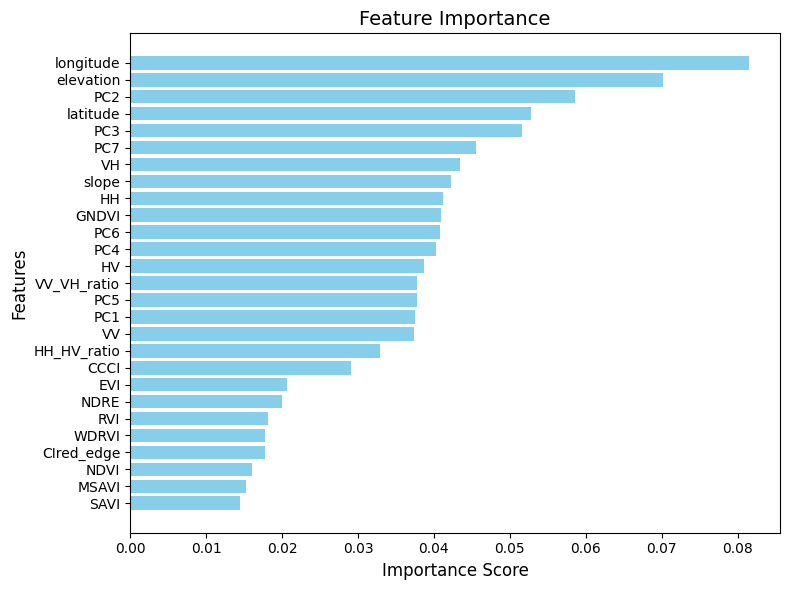

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Fit the Random Forest model
model = RandomForestRegressor(random_state=12345)
model.fit(X_data, y)

# Extract feature importances
importances = model.feature_importances_
feature_names = X_data.columns

# Combine feature names and their importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
sorted_features = feature_importances.sort_values(by='Importance', ascending=True)

# Plot sorted feature importances
plt.figure(figsize=(8, 6))
plt.barh(sorted_features['Feature'], sorted_features['Importance'], color='skyblue')
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
#plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.5 MB/s eta 0:00:00


In [ ]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }

    rf_model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)

    #rf_model = RandomForestRegressor(random_state=12345)

    rf_model.fit(X_train, y_train)
    preds = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return rmse  # minimize RMSE

In [ ]:
# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)

[I 2025-04-26 00:12:40,997] A new study created in memory with name: no-name-c3708835-d56b-4f87-a4c7-8db64f3a9b82
[I 2025-04-26 00:12:56,641] Trial 0 finished with value: 106.61651346165259 and parameters: {'n_estimators': 571, 'max_depth': 9, 'learning_rate': 0.0010876681921020187, 'subsample': 0.8376846538101288, 'colsample_bytree': 0.7952621814806278, 'min_child_weight': 4}. Best is trial 0 with value: 106.61651346165259.
[I 2025-04-26 00:12:57,384] Trial 1 finished with value: 109.2523848233378 and parameters: {'n_estimators': 174, 'max_depth': 5, 'learning_rate': 0.19930905966841148, 'subsample': 0.7360639446582864, 'colsample_bytree': 0.9217951672155993, 'min_child_weight': 8}. Best is trial 0 with value: 106.61651346165259.
[I 2025-04-26 00:13:03,684] Trial 2 finished with value: 105.37499679039546 and parameters: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.0037659272798520513, 'subsample': 0.9558187762171089, 'colsample_bytree': 0.5037457403281103, 'min_child_weigh

In [ ]:
# Print best result
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best RMSE: 102.98859842045012
Best hyperparameters: {'n_estimators': 1749, 'max_depth': 7, 'learning_rate': 0.003783128316209009, 'subsample': 0.7793914158733822, 'colsample_bytree': 0.9907056835765793, 'min_child_weight': 1}


In [ ]:
study.best_trial.value

104.62987591915419

In [ ]:
study.best_trial.params

{'n_estimators': 679,
 'max_depth': 4,
 'learning_rate': 0.009985907796275569,
 'subsample': 0.6169137774100129,
 'colsample_bytree': 0.9271487226974005,
 'min_child_weight': 8}

In [ ]:
# save the model

best_params = study.best_trial.params

best_model = xgb.XGBClassifier(**best_params)

best_model.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 5239 5240 5241], got [ 13.52122879  13.58285999  13.60262012 ... 825.142456   840.338501
 940.638184  ]

In [ ]:
import joblib

joblib.dump(best_model, 'best_xgb_model.joblib')

In [ ]:
parameters = {
    'rf_model__n_estimators': [100, 150, 200, 300],  # Number of trees
    'rf_model__criterion': ['squared_error', 'absolute_error'],  # Error metrics
    'rf_model__max_depth': [10, 20, 30, None],  # Tree depth
    'rf_model__min_samples_split': [2, 5, 10],  # Minimum samples for a split
    'rf_model__min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'rf_model__max_features': ['sqrt', 'log2', 'auto'],  # Features considered per split
    'rf_model__bootstrap': [True, False],  # Bootstrap samples
}

In [ ]:
# Set up GridSearchCV
from datetime import datetime
start_time = datetime.now()

xgb_grid = GridSearchCV(rf_pipe,
                   param_grid=parameters,
            cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_result = xgb_grid.fit(X_train, y_train)

end_time = datetime.now()
taken_time = end_time - start_time
print(f"GridSearchCV took {taken_time} (hh:mm:ss).")

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


In [ ]:
#learning_rate': 0.1,'max_depth': 4,'min_child_weight': 6,'n_estimators': 60,'subsample': 0.5
grid_result.best_params_

{'rf_model__bootstrap': True,
 'rf_model__max_depth': 30,
 'rf_model__max_features': 'sqrt',
 'rf_model__min_samples_leaf': 2,
 'rf_model__min_samples_split': 10,
 'rf_model__n_estimators': 500}

In [ ]:
# Access the best parameters, estimator, and score
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'rf_model__bootstrap': True, 'rf_model__max_depth': 30, 'rf_model__max_features': 'sqrt', 'rf_model__min_samples_leaf': 2, 'rf_model__min_samples_split': 10, 'rf_model__n_estimators': 500}


In [ ]:
best_score = grid_result.best_score_
print("Best Score (MSE):", -best_score)

Best Score (MSE): 9560.651248984901


In [ ]:
best_estimator = grid_result.best_estimator_
print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('rf_model',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=10,
                                       n_estimators=500, random_state=12345))])


In [ ]:
y_pred = best_estimator.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

106.28230233390683


In [ ]:
y_pred_val = best_estimator.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred_val)
print(np.sqrt(mse_val))

98.07372890448548


In [ ]:
# Define the function to run the model with parameter tuning
def run_best_model(ml_pipe, X_train, y_train, X_test, y_test, params):
  ml_pipe.set_params(**params)
  ml_pipe.fit(X_train, y_train)
  y_pred = ml_pipe.predict(X_test)
  test_score = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  # save the model to disk
  #filename = '/content/drive/MyDrive/Biomass_Prediction_Using_GEE/agbd_model.sav'
  #pk.dump(ml_pipe, open(filename, 'wb'))

  return np.sqrt(test_score), y_pred, mae, r2

In [ ]:
# Run the model with the specified parameters
params = {'xgbr_model__colsample_bytree': 0.2,
 'xgbr_model__learning_rate': 0.1,
 'xgbr_model__max_depth': 3,
 'xgbr_model__min_child_weight': 4,
 'xgbr_model__n_estimators': 60,
 'xgbr_model__objective': 'reg:linear',
 'xgbr_model__reg_alpha': 0,
 'xgbr_model__reg_lambda': 0,
 'xgbr_model__subsample': 0.5}

In [ ]:
params = {'xgbr_model__colsample_bytree': 0.5,
 'xgbr_model__learning_rate': 0.1,
 'xgbr_model__max_depth': 4,
 'xgbr_model__min_child_weight': 4,
 'xgbr_model__n_estimators': 70,
 'xgbr_model__objective': 'reg:linear',
 'xgbr_model__reg_alpha': 0,
 'xgbr_model__reg_lambda': 0,
 'xgbr_model__subsample': 0.5}

In [ ]:
params = best_params

test_score, y_pred, mae, r2 = run_best_model(best_estimator, X_train, y_train, X_test, y_test, params)

print(f"Model RMSE: {test_score}")
print()
print(f"Model MAE: {mae}")
print()
print(f"r2 Score: {r2}")

Model RMSE: 106.28230233390683

Model MAE: 80.53603199536548

r2 Score: 0.06036105816508641


In [ ]:
# Save the model to disk
filename = '/content/drive/MyDrive/Biomass_Prediction_Using_GEE/agbd_model.sav
with open(filename, 'wb') as model_file:
  pk.dump(model, model_file)

Create a feature importance graph.

# Check Model Performance
## Check the RF model performance using the training set.
Generate sample points for the training and predicted AGBD. Next, compute RMSE for the training set.

In [ ]:
# Calculate RMSE
def calculate_rmse(input_fc):
    observed = ee.Array(input_fc.aggregate_array('agbd'))
    predicted = ee.Array(input_fc.aggregate_array('predicted'))
    rmse = observed.subtract(predicted).pow(2).reduce('mean', [0]).sqrt().get([0])
    return rmse

predicted_training = training.classify(rf_regressor, 'predicted')
rmse = calculate_rmse(predicted_training).getInfo()
print('RMSE:', rmse)

# Calculate R²
observed_values = np.array(predicted_training.aggregate_array('agbd').getInfo())
predicted_values = np.array(predicted_training.aggregate_array('predicted').getInfo())
r2 = np.corrcoef(observed_values, predicted_values)[0, 1] ** 2
print('R²:', r2)

# Create a plot of observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(observed_values, predicted_values, c='#525252', s=20, label='Data points')
plt.plot([observed_values.min(), observed_values.max()], [observed_values.min(), observed_values.max()], 'k--', lw=2, label='1:1 Line')

# Linear fit
slope, intercept = np.polyfit(observed_values, predicted_values, 1)
plt.plot(observed_values, slope * observed_values + intercept, 'r', label=f'Linear Fit (R² = {r2:.2f})')

plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha)')
plt.legend()
plt.show()

## Check the RF model performance using the test (validation) set.
Perform model validation for the test (validation) set.


In [ ]:
# Predict AGBD for the test data
predicted_testing = testing.classify(rf_regressor, 'predicted')
observed_testing_values = np.array(predicted_testing.aggregate_array('agbd').getInfo())
predicted_testing_values = np.array(predicted_testing.aggregate_array('predicted').getInfo())

# Calculate RMSE and R² for the validation data
rmse_testing = np.sqrt(mean_squared_error(observed_testing_values, predicted_testing_values))
r2_testing = r2_score(observed_testing_values, predicted_testing_values)
print('Test RMSE:', rmse_testing)
print('Test R²:', r2_testing)

# Create a plot of observed vs. predicted values for the test data
plt.figure(figsize=(10, 6))
plt.scatter(observed_testing_values, predicted_testing_values, c='#525252', s=20, label='Data points')
plt.plot([observed_testing_values.min(), observed_testing_values.max()], [observed_testing_values.min(), observed_testing_values.max()], 'k--', lw=2, label='1:1 Line')
slope, intercept = np.polyfit(observed_testing_values, predicted_testing_values, 1)
plt.plot(observed_testing_values, slope * observed_testing_values + intercept, 'r', label=f'Linear Fit (R² = {r2_testing:.2f})')
plt.xlabel('Observed AGBD (Mg/Ha)')
plt.ylabel('Predicted AGBD (Mg/Ha)')
plt.title('Aboveground Biomass Density (Mg/Ha) - Test Data')
plt.legend()
plt.show()

## Predict and Visualize AGBD
Let's predict the aboveground biomass density (AGBD) and then display the map.

In [ ]:
# Predict AGBD
regression = clippedmergedCollection.select(bands).classify(rf_regressor, 'predicted').clip(banco_forest_boundary)

# Define a custom palette to display the AGBD map
palette = ['#FFFF00', '#ADFF2F', '#32CD32', '#2E8B57', '#006400']

# Prepare visualization parameters to display the AGBD regression on the map
viz = {
  'min': 0,
  'max': 220,
  'palette': palette}

# Initialize the map
map5 = geemap.Map()
map5.centerObject(banco_forest_boundary, 12)

# Add visualization parameters
map5.addLayer(regression, viz, 'AGBD map')
map5.add_colorbar(viz, label="AGBD (Mg/ ha)", layer_name="AGBD map")

# Display the AGBD map
map5

## Export AGBD Map
Export the AGBD map to Google Drive.

In [ ]:
# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': regression,
    'description': 'Mafungautsi_AGBD_S1_PALSAR_S2_2021',
    'folder':'export',
    'scale': 30,
    'region': banco_forest_boundary.geometry().getInfo()['coordinates'],
    'maxPixels': 1e10
})

task.start()

## Key Takeaways

The random forest model is overfitting because it performs significantly better on the training data than on the test data. Several factors may contribute to this overfitting in this case study. The next tutorial will focus on increasing the quality and quantity of GEDI L4A AGBD sample points. We will also analyze sensitivity to determine which scale provides the best model results.


## References


Horler, D. N. H., Dockray, M., & Barber, J. (1983). The red edge of plant leaf reflectance. International Journal of Remote Sensing, 4(2), 273-288. https://doi.org/10.1080/01431168308948546[4]


Huete, A. R. (1988). A soil-adjusted vegetation index (SAVI). Remote Sensing of Environment, 25, 295-309.


Macave, O. A., Ribeiro, N. S., Ribeiro, A. I., Chaúque, A., Bandeira, R., Branquinho, C., & Washington-Allen, R. (2022). Modelling aboveground biomass of Miombo woodlands in Niassa Special Reserve, Northern Mozambique. Forests, 13(2), 311. https://doi.org/10.3390/f13020311


Rouse, J. W., Jr., Haas, R. H., Schell, J. A., & Deering, D. W. (1974). Monitoring vegetation systems in the great plains with ERTS. In S. C. Fraden, E. P. Marcanti, & M. A. Becker (Eds.), Third ERTS-1 Symposium, 10–14 Dec. 1973, NASA SP-351 (pp. 309-317). NASA.


Xiao, C., Li, P., Feng, Z., Liu, Y., & Zhang, X. (2020). Sentinel-2 red-edge spectral indices (RESI) suitability for mapping rubber boom in Luang Namtha Province, northern Lao PDR. International Journal of Applied Earth Observation and Geoinformation, 93, 102176.

In [ ]:
def indices(X):
  X["SBI"] = (0.3037 * X["B02"] + 0.2793 * X["B03"] + 0.4743 * X["B04"] +
                0.5585 * X["B08"] + 0.5082 * X["B11"] + 0.1683 * X["B12"])
  X["GVI"] = (0.2848 * X["B02"] + 0.2435 * X["B03"] + 0.5436 * X["B04"] +
                0.7243 * X["B08"] + 0.0840 * X["B11"] + 0.1800 * X["B12"])
  X["WET"] = (0.1509 * X["B02"] + 0.1973 * X["B03"] + 0.3279 * X["B04"] +
                0.3406 * X["B08"] + 0.7112 * X["B11"] + 0.4572 * X["B12"])

  X["AFRI1600"] = (X["B08"]- 0.66*X["B11"]) / (X["B08"] + 0.66*X["B03"])
  X["MTCI"] = (X["B06"] - X["B05"])/(X["B05"] - X["B04"])
  X["NPCRI"] = (X["B04"] - X["B02"]) / (X["B04"] + X["B02"])
  X["TCI"] = 1.2*(X["B05"]-X["B03"])-1.5*(X["B04"]-X["B03"])*(X["B05"]/X["B04"])**0.5
  X["NDCI"] = (X["B05"] - X["B04"]) / (X["B05"] + X["B04"])
  X["NDREI"] = (X["B08"] - X["B05"]) / (X["B08"] + X["B05"])
  X["GNDVI"] = (X["B08"]- X["B03"]) / (X["B08"]+X["B03"])
  X["NDVI"] = (X["B08"] - X["B04"]) / (X["B08"] + X["B04"])
  X["ENDVI"] = ((X["B08"]-X["B03"]) -(2*X["B02"]))/((X["B08"]-X["B03"]) + (2*X["B02"]))
  X["MNDVI"] = (X["B08"] - X["B11"]) / (X["B08"] + X["B11"])
  X["NBR"] = (X["B08"] - X["B12"]) / (X["B08"] + X["B12"])
  X["EVI"] = 2.5 * (X["B08"] - X["B04"]) / (X["B08"] + 6 * X["B04"] - 7.5 * X["B02"] + 1)
  X["RVI"] = X["B08"]/X["B04"]
  X["SAVI"] = (1.0+0.5)*(X["B08"] - X["B04"]) / (X["B08"] + X["B04"] + 0.5)
  X["SLAVI"] = X["B08"]/(X["B04"] + X["B12"])
  TNDVI = [(x)**(1/2.0) for x in ((X["B08"] - X["B04"]) / (X["B08"] + X["B04"]) + 0.5)]
  X["TNDVI"] = np.array(TNDVI)
  X["NDII"] = (X["B08"] - X["B11"])/(X["B08"] + X["B11"])
  X["MSR"] = ((X["B08"]/X["B04"]-1) + (X["B08"]/X["B04"]+1)**(0.5))
  X["NLI"] = ((X["B08"]**2 - X["B04"]) / (X["B08"]**2 + X["B04"]))
  X["DVI"] = X["B08"] - X["B04"]
  X["RYI"] = X["B03"] / X["B02"]
  X["MRESR"] = (X["B06"] - X["B01"]) / (X["B05"] - X["B01"])
  X["NHFD"] = (X["B05"]-X["B01"])/(X["B05"]+X["B01"])
  X["ARVI"] = (X["B08"] - (2 * X["B04"]) + X["B02"]) / (X["B08"] + (2 * X["B04"]) + X["B02"])
  X["MSAVI"] = 0.5*(2 * X["B08"] + 1 - (((2 * X["B08"]+1)**2) - 8*(X["B08"] - X["B04"]))**0.5)
  X["CVI"] = (X["B08"]*X["B04"]) / (X["B03"]**2)
  X["FCVI"] = X["B08"] - ((X["B04"] + X["B03"] + X["B02"])/3)
  X["GLI"] = (2 * X["B03"] - X["B04"] - X["B02"]) / (2 * X["B03"] + X["B04"] + X["B02"])
  X["NDBI"] = (X["B11"] - X["B08"]) / (X["B11"] + X["B08"])
  X["DBSI"] = ((X["B11"] - X["B03"])/(X["B11"] + X["B03"])) - ((X["B08"] + X["B04"])/(X["B08"] + X["B04"]))
  X["NDWI"] = (X["B03"] - X["B08"])/(X["B03"]+  X["B08"])
  X["MNDWI"] = (X["B03"] - X["B08"]) / (X["B03"] + X["B08"])
  X["NDYI"] = (X["B03"] - X["B02"]) / (X["B03"] + X["B02"])
  X["EXG"] = 2 * X["B03"] - X["B04"] - X["B02"]
  X["SIPI"] = (X["B08"] - X["B02"]) / (X["B08"] - X["B04"])
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(X["B08"], X["B03"], X["B04"]))
  X["MTVI2"] = np.array(MTVI2)
  X["NDWI2"] = (X["B01"]-X["B08"])/(X["B01"]+X["B08"])
  X["S2REP"] = 705 + 35 * ((((X["B07"] + X["B04"])/2) - X["B05"])/(X["B06"] - X["B05"]))
  X["CCCI"] = ((X["B08"] - X["B05"]) / (X["B08"] + X["B05"])) / ((X["B08"] - X["B04"]) / (X["B08"] + X["B04"]))
  X["MCARI"] = ((X["B05"] - X["B04"]) - 0.2*(X["B05"] - X["B03"])) * (X["B05"]/X["B04"])
  X["TCARI"] = 3 * ((X["B05"] - X["B04"]) - 0.2 * (X["B05"] - X["B03"]) * (X["B05"] / X["B04"]))
  X["PVI"] = (X["B08"] - 0.3 * X["B04"] - 0.5) / ((1 + 0.3 * 2) ** (1/2.0))
  X["RENDVI"] = (X["B06"] - X["B05"]) / (X["B06"] + X["B05"])
  X["MRESR"] = (X["B06"] - X["B01"]) / (X["B05"] - X["B01"])
  X["TTVI"] = 0.5*((865.0-740.0)*(X["B8A"]-X["B06"]-(X["B07"]-X["B06"])*(783.0-740)))
  X["NDSWIR"] = (X["B11"]-X["B8A"])/(X["B11"]+X["B8A"])
  X["NBRSWIR"] = (X["B12"]-X["B11"]-0.02)/(X["B12"]+X["B11"]+0.1)
  X["NBRplus"] = (X["B12"]-X["B8A"]-X["B03"]-X["B02"])/(X["B12"]+X["B8A"]+X["B03"]+X["B02"])
  X["NDDI"] = (( (X["B08"]-X["B04"])/(X["B08"]+X["B04"])-((X["B03"]-X["B08"])/(X["B03"]+X["B08"])))/((X["B08"]-X["B04"])/(X["B08"]+X["B04"]))+((X["B03"]-X["B08"])/(X["B03"]+X["B08"])))

  return X

In [ ]:
X_ind = X_data.copy()
veg_indices_data = indices(X_ind)

tab = list(range(12))
X_index = veg_indices_data.drop(veg_indices_data.iloc[:,tab],axis = 1)
X_index.head()

,SBI,GVI,WET,AFRI1600,MTCI,NPCRI,TCI,NDCI,NDREI,GNDVI,NDVI,ENDVI,MNDVI,NBR,EVI,RVI,SAVI,SLAVI,TNDVI,NDII,MSR,NLI,DVI,RYI,MRESR,NHFD,ARVI,MSAVI,CVI,FCVI,GLI,NDBI,DBSI,NDWI,MNDWI,NDYI,EXG,SIPI,MTVI2,NDWI2,S2REP,CCCI,MCARI,TCARI,PVI,RENDVI,TTVI,NDSWIR,NBRSWIR,NBRplus,NDDI
0,2995.247839,2872.592130,2635.943189,0.583438,3.240186,-0.180510,765.184292,0.342550,0.529300,0.618675,0.738036,0.275448,0.338948,0.627414,7.685491,6.634627,1.106885,2.633882,1.112671,0.338948,8.397710,0.999894,2419.982659,1.084989,7.883737,0.136491,0.602984,0.849253,2.715896,2276.317759,0.123130,-0.338948,-0.646050,-0.618675,-0.618675,0.040762,294.369942,0.921815,2.750898e+07,-0.620933,724.018707,0.717175,829.880011,1090.536939,2150.444888,0.452573,-1.491620e+06,-0.378064,-0.366373,-0.742122,1.219598
1,3929.206928,3554.996255,3743.718742,0.514749,2.627328,-0.066631,1237.165745,0.472407,0.520151,0.684323,0.796773,0.517293,0.220439,0.529305,3.125071,8.841194,1.195011,2.375916,1.138759,0.220439,10.978261,0.999938,3226.167287,1.449997,4.273268,0.346848,0.666221,0.886879,3.219996,3116.478509,0.214643,-0.220439,-0.453706,-0.684323,-0.684323,0.183672,481.903462,0.981792,4.607975e+07,-0.734488,721.717868,0.652823,1795.898060,1429.298416,2777.803267,0.457392,-1.681840e+06,-0.280684,-0.349660,-0.650586,1.174546
2,3576.631640,3118.041380,3524.728279,0.437512,2.666091,-0.038195,935.114856,0.400012,0.494617,0.644573,0.746861,0.429498,0.137852,0.449422,3.068593,6.900797,1.120130,1.905591,1.116629,0.137852,8.711633,0.999904,2582.857418,1.381670,4.192598,0.313372,0.599207,0.855069,3.102468,2499.570969,0.178457,-0.137852,-0.443862,-0.644573,-0.644573,0.160253,395.425816,0.986540,3.061751e+07,-0.699558,721.869554,0.662262,1189.887802,1234.954100,2283.762729,0.432385,-1.362945e+06,-0.203292,-0.332144,-0.599467,1.218470
3,4212.892810,3849.969203,3946.455280,0.509785,2.649788,-0.180060,1170.814832,0.387253,0.498757,0.622445,0.742584,0.286871,0.231436,0.513094,7.294631,6.769510,1.113745,2.129853,1.114712,0.231436,8.556894,0.999921,3179.000000,1.094578,7.651322,0.125125,0.608178,0.852262,2.727853,2992.666667,0.127273,-0.231436,-0.543185,-0.622445,-0.622445,0.045154,392.000000,0.923875,4.729589e+07,-0.587234,722.518141,0.671651,1404.958325,1573.921883,2817.747509,0.425185,-1.806029e+06,-0.289651,-0.319608,-0.661305,1.215770
4,3820.016737,3507.396331,3534.546645,0.513755,2.374047,-0.134587,1224.952683,0.408097,0.474470,0.601620,0.739397,0.313270,0.243049,0.552878,4.988680,6.674522,1.108955,2.284384,1.113282,0.243049,8.444815,0.999912,2908.518738,1.266320,4.314143,0.262005,0.599422,0.850158,2.421609,2742.582070,0.179235,-0.243049,-0.580018,-0.601620,-0.601620,0.117512,517.347754,0.945187,4.033286e+07,-0.655044,721.777677,0.641698,1506.105539,1594.511288,2582.639245,0.407600,-1.655569e+06,-0.294401,-0.357920,-0.688754,1.212043


In [ ]:
X_index.shape

(317, 51)

In [ ]:
#training_data = pd.concat([coord,pca_df,X_index,y],axis=1)
training_data = pd.concat([coord,X_data,y],axis=1)
training_data.head()

,Latitude,Longitude,B02,B03,B04,B08,B05,B06,B07,B8A,B11,B12,B01,B09,biomass_mg_ha
0,6.70660,-3.63924,618.690591,671.272319,429.484104,2849.466763,877.030206,2327.162596,2900.555913,3117.161311,1406.809126,652.366324,666.369565,2764.804348,125.038569
1,6.69001,-3.69883,470.181354,681.761550,411.438284,3637.605572,1148.241189,3084.064427,3734.349119,4136.868943,2323.536344,1119.594714,556.837438,4021.019704,163.326869
2,6.68897,-3.69699,472.477614,652.808376,437.713321,3020.570740,1021.360865,2577.418514,3105.008315,3456.667406,2288.681264,1147.396341,533.965517,3575.650246,126.711793
3,6.67996,-3.68850,793.000000,868.000000,551.000000,3730.000000,1247.458937,3092.927536,3791.299517,4226.463768,2327.966184,1200.294686,970.000000,3758.000000,168.293431
4,6.68558,-3.64509,671.981538,850.943373,512.557454,3421.076192,1219.338470,2897.269675,3534.793065,3821.667034,2083.252614,985.035223,713.044335,3636.433498,81.424264


In [ ]:
training_data.shape

(317, 15)

In [ ]:
#training_data.isna().sum()

In [ ]:
y = training_data['biomass_mg_ha']
X = training_data.drop(['biomass_mg_ha'],axis=1)

## Modelisation

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
min(y),max(y)

(0.0, 461.0)

#### lgblm

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.1,random_state=12345)
#X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train, test_size=0.1,random_state=12345)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((285, 39), (32, 39), (285,), (32,))

In [ ]:
parameters = {'learning_rate': [0.1,0.01,0.2], #so called `eta` value
              'max_depth': [3,4,5],
              #'min_child_weight': [3,4,5],
              #'silent': [1],
              'subsample': [0.1,0.2,0.3],
              #'colsample_bytree': [0.1,0.01,0.2 ],
              'n_estimators': [5000,10000]}

In [ ]:
# Instantiate model
model = LGBMRegressor(objective = 'quantile')

# Train model
#model.fit(X_train, y_train)
xgb_grid = GridSearchCV(model,
                   param_grid=parameters,
            cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

start_time = timer(None)
grid_result = xgb_grid.fit(X_train, y_train)
timer(start_time)
# Make predictions
#preds = model.predict(X_test)

# Check top 25 features
#lightgbm.plot_importance(model, max_num_features=25, figsize = (12,5));

KeyboardInterrupt: 

In [ ]:
grid_result.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10000, 'subsample': 0.1}

In [ ]:
model = grid_result.best_estimator_
preds = model.predict(X_test)

In [ ]:
# previous value 25437.1042612838
mse = mean_squared_error(y_test,preds)
print(np.sqrt(mse))

50.10620579326125


In [ ]:
y_pred_train = model.predict(X_train)
x = pd.DataFrame({"truth":y_train,"preds":y_pred_train})
x.sort_values(by=['preds'])

,truth,preds
123,0.000000,-0.005656
125,0.000000,0.003613
128,0.000000,0.007323
119,0.000000,2.517829
249,2.886302,2.886275
...,...,...
9,263.173239,263.944429
22,183.582418,269.733539
85,305.017349,305.051592
40,391.127554,320.531578


In [ ]:
x_test = pd.DataFrame({"truth":y_test,"preds":preds})
x_test.sort_values(by=['preds'])

,truth,preds
223,0.000000,-11.888734
229,0.000000,3.962830
178,28.315409,26.750176
193,23.863505,48.660392
162,0.000000,50.105309
195,66.157392,55.102986
207,28.326170,58.488963
177,4.319714,59.739632
120,0.000000,62.445497
165,0.000000,65.960532


In [ ]:
import pickle

In [ ]:
# save the model to disk
filename = '/content/drive/MyDrive/ETH_GIZ/New_Approach_AGBD_estimation/Models/new_version_model.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X_test)
x = pd.DataFrame({"truth":y_test,"preds":y_pred})
x_test.sort_values(by=['preds'])

,truth,preds
24,89612.269131,50431.132017
154,36988.489920,52340.216688
35,57079.163401,58714.391898
147,33546.047019,59500.689478
141,61651.847698,60300.599001
137,29715.162762,63272.565251
95,52819.019077,63572.401656
10,71049.026272,64456.943438
139,54397.689012,65211.133204
70,95795.124474,65630.890832


#### xgb

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=12345)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((253, 14), (64, 14), (253,), (64,))

#### CV

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=12345)
xgbr_pipe = Pipeline(steps=[('xgbr_model',xgb_model)])

In [ ]:
scores = cross_validate(
    estimator=xgbr_pipe, # model to evaluate
    X=X, # inputs features
    y=y, # output labels
    cv=30, # how many folds
    # list of model evaluation metrics
    scoring=['neg_mean_squared_error'])

In [ ]:
np.sqrt(-scores["test_neg_mean_squared_error"].mean())

70.54158486689882

In [ ]:
xgbr_pipe.fit(X_train, y_train)

y_pred = xgbr_pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

61.55326696112893


In [ ]:
x_test = pd.DataFrame({"truth":y_test,"preds":y_pred})
x_test.sort_values(by=['preds']).head()

,truth,preds
316,0.0,-0.911429
308,0.0,-0.651224
305,0.0,-0.618289
291,0.0,-0.300145
298,0.0,-0.106878


In [ ]:
y_pred_train = xgbr_pipe.predict(X_train)
x = pd.DataFrame({"truth":y_train,"preds":y_pred_train})
x.sort_values(by=['preds']).head()

,truth,preds
297,0.0,-0.002269
217,0.0,-0.002042
300,0.0,-0.001599
162,0.0,-0.001568
299,0.0,-0.001230


In [ ]:
mse1 = mean_squared_error(y_train, y_pred_train)
print(np.sqrt(mse1))

0.0010104993318731206


#### Grid search

In [ ]:
parameter = {'xgbr_model__n_estimators': np.arange(70,100,5),
    'xgbr_model__max_depth': np.arange(4,7,1),
    'xgbr_model__learning_rate': [0.01,0.1,0.5],
    'xgbr_model__min_child_weight': np.arange(4,10,1),
    'xgbr_model__objective':['reg:linear','reg:squarederror','reg:squaredlogerror'],
    'xgbr_model__reg_alpha':[0,0.1,1],
    'xgbr_model__reg_lambda':[0,0.1,1],
    'xgbr_model__subsample': np.arange(0.5,0.7,0.1),
    'xgbr_model__colsample_bytree': np.arange(0.5,0.7,0.1)}

In [ ]:
parameters = {'xgbr_model__learning_rate': [0.1],
              'xgbr_model__max_depth': [6,7,8,10],
              'xgbr_model__min_child_weight': [7,10,20],
              'xgbr_model__reg_alpha':[0,0.1,1],
              'xgbr_model__reg_lambda':[0,0.1,1],
              #'xgbr_model__objective':['reg:linear','reg:squarederror','reg:squaredlogerror'],
              'xgbr_model__subsample': [0.5,0.6],
              'xgbr_model__colsample_bytree': [0.5,0.6],
              'xgbr_model__n_estimators': [300,400,500]}

In [ ]:
parameters = {'xgbr_model__learning_rate': [0.1,0.01,0.2],
              'xgbr_model__max_depth': [2,3,4,5],
              'xgbr_model__min_child_weight': [2,4,5,6],
              'xgbr_model__reg_alpha':[0,0.1,0.2,1],
              'xgbr_model__reg_lambda':[0,0.1,0.2,1],
              'xgbr_model__objective':['reg:linear','reg:squarederror','reg:squaredlogerror'],
              #'silent': [1],
              'xgbr_model__subsample': [0.4,0.5,0.6],
              #'colsample_bytree': [0.1,0.01,0.2],
              'xgbr_model__n_estimators': [50,60,70]}

In [ ]:
xgb_grid = GridSearchCV(xgbr_pipe,
                   param_grid=parameters,
            cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)


start_time = timer(None)
grid_result = xgb_grid.fit(X_train, y_train)
timer(start_time)


 Time taken: 3 hours 51 minutes and 4.79 seconds.


In [ ]:
#learning_rate': 0.1,'max_depth': 4,'min_child_weight': 6,'n_estimators': 60,'subsample': 0.5
grid_result.best_params_

{'xgbr_model__learning_rate': 0.2,
 'xgbr_model__max_depth': 4,
 'xgbr_model__min_child_weight': 2,
 'xgbr_model__n_estimators': 60,
 'xgbr_model__objective': 'reg:linear',
 'xgbr_model__reg_alpha': 0.1,
 'xgbr_model__reg_lambda': 1,
 'xgbr_model__subsample': 0.6}

In [ ]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

61.47086720101155


In [ ]:
xgb_model_tuning = xgb.XGBRegressor(random_state=12345, colsample_bytree= 0.4,
                                    learning_rate= 0.1,
                                    max_depth= 3,
                                    reg_lambda=2,
                                    min_child_weight=0.2,
                                    n_estimators=400,
                                    subsample= 0.8000000000000002)

In [ ]:
best_model = xgb_model_tuning.fit(X_train, y_train)

In [ ]:
y_pred = best_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

61.57952200521192


In [ ]:
# Define the function to run the model with parameter tuning
def run_best_model(ml_pipe, X_train, y_train, X_test, y_test, params):
  ml_pipe.set_params(**params)
  ml_pipe.fit(X_train, y_train)
  y_pred = ml_pipe.predict(X_test)
  test_score = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  # save the model to disk
  #filename = '/content/drive/MyDrive/Features_from_GEE/Models/S2_new_model50.sav'
  #pk.dump(ml_pipe, open(filename, 'wb'))

  return np.sqrt(test_score), y_pred, mae, r2

In [ ]:
# Run the model with the specified parameters  52
params = {'xgbr_model__colsample_bytree': 0.8,
 'xgbr_model__learning_rate': 0.1,
 'xgbr_model__max_depth': 6,
 'xgbr_model__min_child_weight': 10,
 'xgbr_model__n_estimators': 300,
 'xgbr_model__subsample': 0.6}

In [ ]:
params = {'xgbr_model__learning_rate': 0.1, # 50
 'xgbr_model__max_depth': 7,
 'xgbr_model__min_child_weight': 7,
 'xgbr_model__n_estimators': 70,
 'xgbr_model__objective': 'reg:linear',
 'xgbr_model__reg_alpha': 0,
 'xgbr_model__reg_lambda': 0.1,
 'xgbr_model__subsample': 0.6}

In [ ]:
#params = best_params

test_score, y_pred, mae, r2 = run_best_model(xgbr_pipe, X_train, y_train, X_test, y_test, params)

print(f"Model RMSE: {test_score}")
print()
print(f"Model MAE: {mae}")
print()
print(f"r2 Score: {r2}")

Model RMSE: 54.601413358302594

Model MAE: 38.18928831640629

r2 Score: 0.6431608694105477


In [ ]:
#params = best_params

test_score, y_pred, mae, r2 = run_best_model(xgbr_pipe, X_train, y_train, X_test, y_test, params)

print(f"Model RMSE: {test_score}")
print()
print(f"Model MAE: {mae}")
print()
print(f"r2 Score: {r2}")

Model RMSE: 55.589780042891434

Model MAE: 36.78788617746915

r2 Score: 0.6301253095578147


In [ ]:
# Save the model to disk
filename = '/content/drive/MyDrive/Features_from_GEE/Models/tsne_pca_mean_51.sav'
with open(filename, 'wb') as model_file:
  pk.dump(model, model_file)

In [ ]:
y_pred_train = model.predict(X_train)
x = pd.DataFrame({"truth":y_train,"preds":y_pred_train})
x.sort_values(by=['preds'])

,truth,preds
228,0.0,-6.394269
222,0.0,-6.113220
119,0.0,-5.688953
227,0.0,-5.109652
125,0.0,-2.740115
...,...,...
275,451.0,444.317200
276,447.0,451.217316
278,461.0,454.195984
280,446.0,455.925140


In [ ]:
x_test = pd.DataFrame({"truth":y_test,"preds":y_pred})
x_test.sort_values(by=['preds'])

## save model

In [ ]:
# load the model from disk
filename = '/content/drive/MyDrive/Features_from_GEE/Models/S2_new_model50.sav'
loaded_model = pk.load(open(filename, 'rb'))
y_preds = loaded_model.predict(X_test)
#pd.DataFrame({"truth":y_test,"preds":y_preds})

loaded_model.fit(X_train, y_train)

y_pred = loaded_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_preds)
r2 = r2_score(y_test, y_pred)

print(np.sqrt(mse))
print()
print(mae)
print()
print(r2)

53.565700295259674

34.230804649150066

0.656569962272078


In [ ]:
import pickle

In [ ]:
# save the model to disk
filename = '/content/drive/MyDrive/Features_from_GEE/Models/finalized_model4.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X_test)
pd.DataFrame({"truth":y_test,"preds":y_pred})

,truth,preds
223,0.000000,5.432275
168,43.773540,33.139320
99,90.973168,144.351593
33,114.693277,169.326630
30,208.407124,143.914764
164,0.000000,48.606220
163,0.000000,33.755947
55,211.343408,258.767883
52,219.167010,118.113106
293,387.000000,358.808716
